In [1]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for Viz things
from matplotlib import pyplot as plt

In [3]:
# using the tensorflow dataset api to load in the data source  
ds=tfds.load("fashion_mnist",split="train")

In [4]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [6]:
# doing some data transformation
import numpy as np

In [7]:
# setting up data iterator
data_iterator=ds.as_numpy_iterator()

In [8]:
# getting data from the input pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

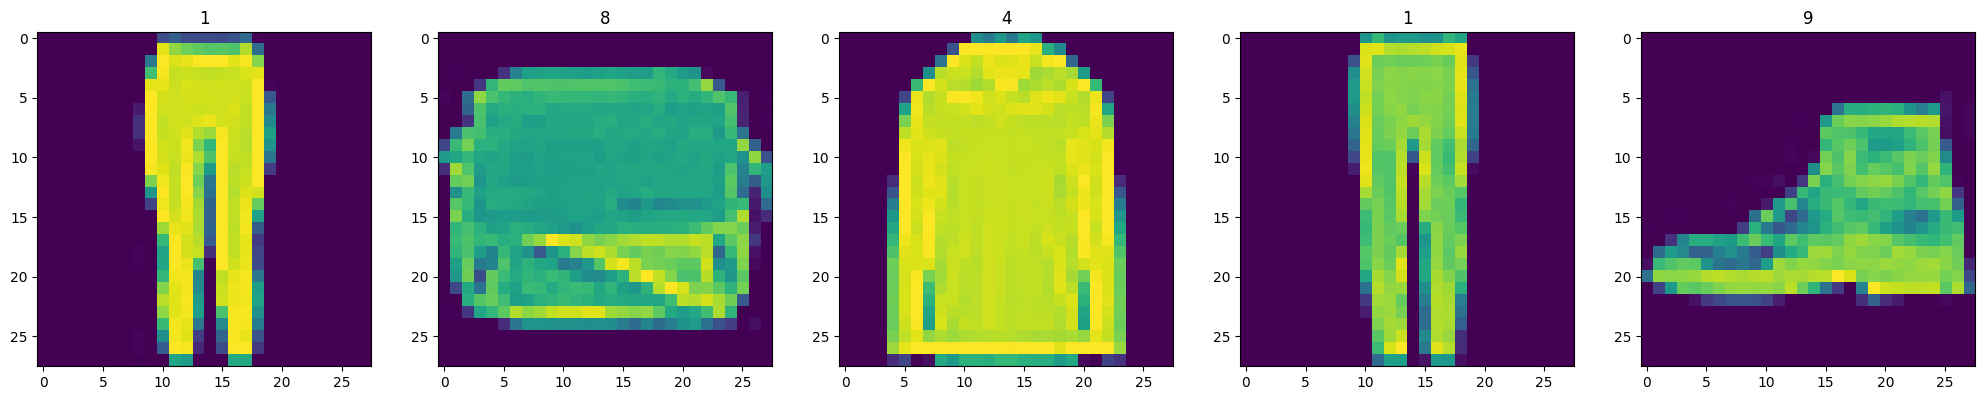

In [9]:
#setting up the subplot formatting
fig1, ax=plt.subplots(ncols=5, figsize=(25,25))
for dx in range(5):
    sample=data_iterator.next()
    ax[dx].imshow(np.squeeze(sample['image']))
    ax[dx].title.set_text(sample['label'])

SCALING/PREPROCESSING

In [10]:
# scaling image and returning images only
def scale_images(data):
    image=data['image']
    return image/255

In [11]:
# Reload the dataset
ds=tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing pipeline
ds=ds.map(scale_images)
# Caching the dataset for that batch
ds=ds.cache()
# shuffle the data up
ds=ds.shuffle(60000)
# grouping the images into a batches of 128
ds=ds.batch(128)
# Reduces the occurance of bottlenecking
ds=ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

BUILDING THE MODEL

In [13]:
# loading the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# loading in the layers for the neural network 
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

In [14]:
def build_generator():
    model=Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(.2))
    model.add(Reshape((7,7,128)))

# Upsampling 2D block
    model.add(UpSampling2D())
    model.add(Conv2D(128,5, padding= 'same'))
    model.add(LeakyReLU(.2))

# Upsampling 2D block
    model.add(UpSampling2D())
    model.add(Conv2D(128,5, padding= 'same'))
    model.add(LeakyReLU(.2))
    
# Convo Block to add more learning parameters 
    model.add(Conv2D(128,4, padding= 'same'))
    model.add(LeakyReLU(.2))

    model.add(Conv2D(128,4, padding= 'same'))
    model.add(LeakyReLU(.2))

# conv2d layer to convert the model to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [15]:
generator=build_generator()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 208ms/step


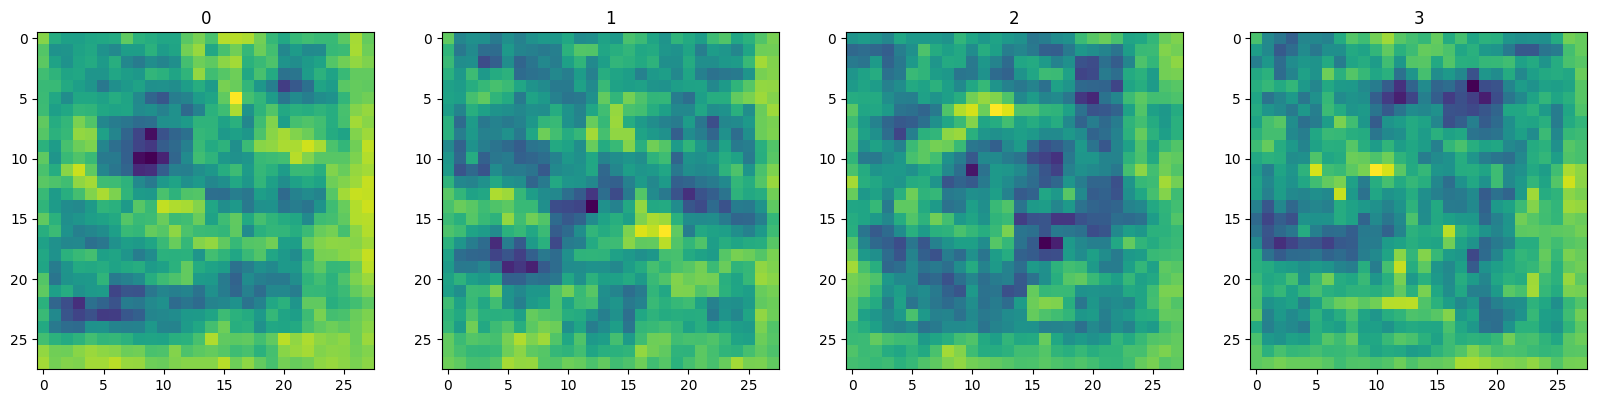

In [31]:
#generating random images
img=generator.predict(np.random.randn(4,128,1))
fig, ax=plt.subplots(ncols=4, figsize=(20,20))

# loop four times to get image
for dx, img in enumerate(img):
    
    ax[dx].imshow(np.squeeze(img))
    ax[dx].title.set_text(dx)

In [46]:
def build_discriminator():

    model=Sequential()

    model.add(Conv2D(32,5, input_shape = (28,28,1)))
    model.add(LeakyReLU(.2))
    model.add(Dropout(.4))


    return model

In [47]:
nator = build_discriminator